In [85]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import math 

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Gráficos
# ==============================================================================
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Asunciones y Preprocesamiento
# ==============================================================================
from scipy import stats
import math
from scipy.stats import levene
import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools

# ANOVA
# ==============================================================================
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA

#Linear Regresion con Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.special import boxcox, inv_boxcox # Invertir el Box-Cox

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Tamaño gráficas
# ==============================================================================
plt.rcParams["figure.figsize"] = (10,8)

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler,OneHotEncoder

## Abrimos el CSV

In [86]:
df= pd.read_csv("Bicicletas_limpio.csv", index_col = 0)
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,spring,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,spring,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,spring,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,spring,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


## OUTLIERS

In [87]:
#Obtenemos las columnas numéricas
numericas = df.select_dtypes(include=np.number)

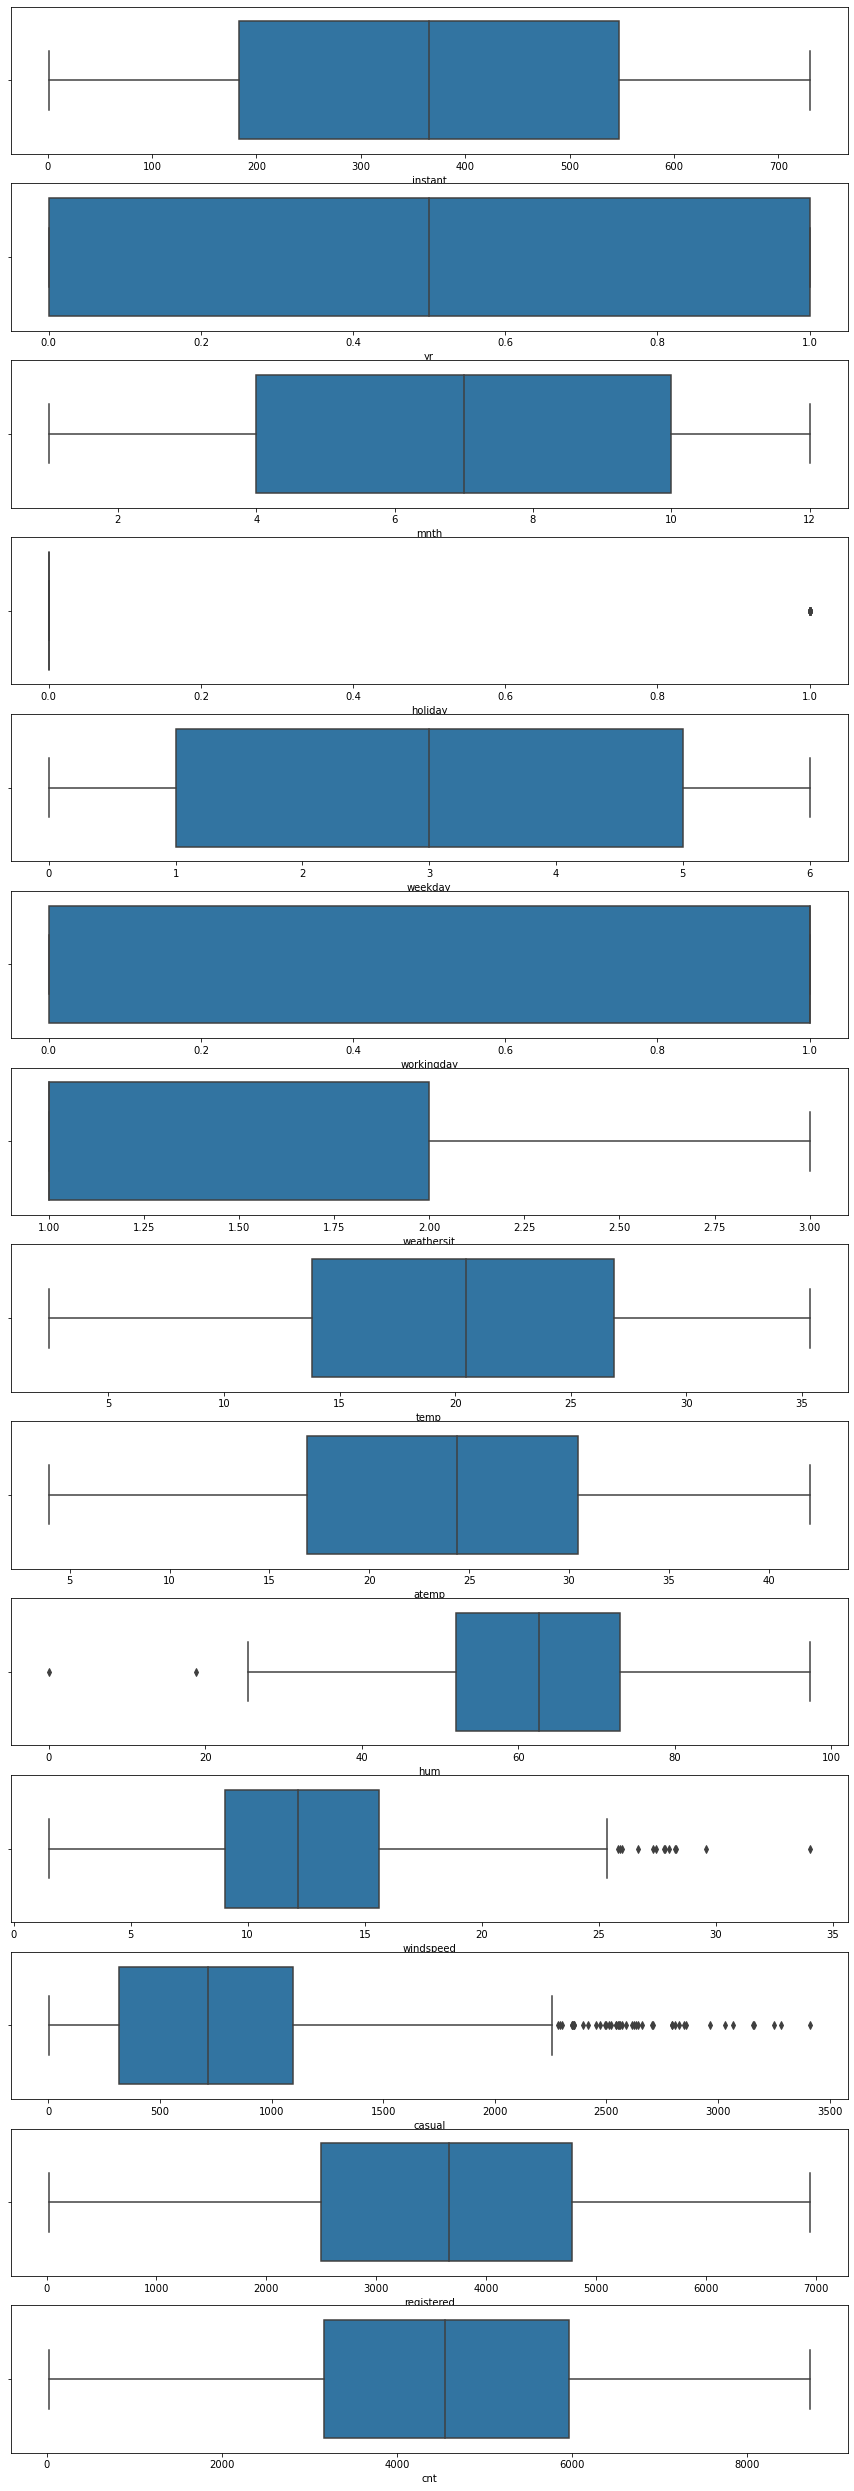

In [88]:
fig, axes = plt.subplots(14, 1, figsize=(15,45))

for i, col in enumerate(numericas):
    sns.boxplot(x = numericas.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

- Observamos outliers en las variables de **hum, windspeed y casual**. Pero decidimos no reemplazarlos ya que podria darnos información sobre por ejemplo, los días con más viento, si afecta o no al alquiler de bicis. LOs outliers en casual también son informativos ya que veremos que días han alquilado más bicis personas que no están registradas.

- También elegimos no usar las variables **instant** y **dteday** porque no van a influir mucho en las demás, por lo que pasamos a eliminarlas de nuestro df.

In [89]:
df = df.drop(columns=['instant', 'dteday'])

- Elegimos como nuestra ***variable respuesta 'registered'***, queremos saber que relación tienen las demás variables

## Comprobaciones de asunciones

### Asunción de normalidad

| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

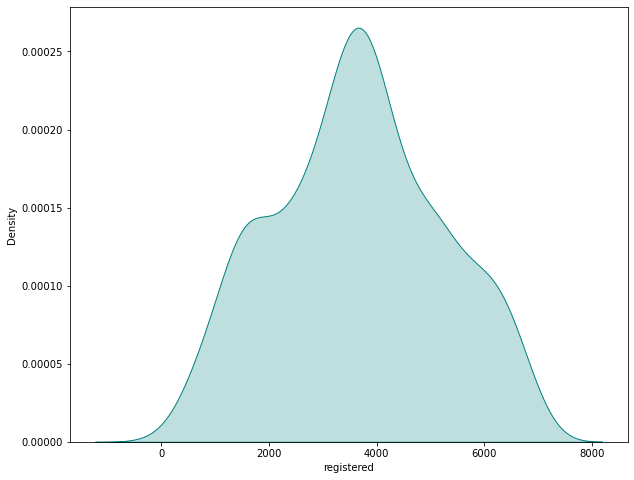

In [90]:
sns.distplot(df.registered, 
            hist = False, 
            color = 'teal', 
            kde_kws = {'shade':True, 'linewidth':1});

- A primera vista vemos que no siguen una distribución normal.

Comprobamos analíticamente

In [91]:
stats.shapiro(df["registered"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

In [92]:
df_raiz= df.copy()

In [93]:
df_raiz["registered_raiz"]= df_raiz["registered"].apply(lambda x: math.sqrt(x))

In [94]:
stats.shapiro(df_raiz["registered_raiz"])

ShapiroResult(statistic=0.9734106659889221, pvalue=2.97543378824372e-10)

In [95]:
df_log= df.copy()

In [96]:
df_log['registered_log'] = df_log['registered'].apply(lambda x: np.log(x) if x != 0 else 0)

In [97]:
stats.shapiro(df_log["registered_log"])

ShapiroResult(statistic=0.8750768303871155, pvalue=9.986205976410893e-24)

In [98]:
df_boxcox = df.copy()

In [99]:
df_boxcox['registered_boxcox'], lambda_ajustada = stats.boxcox(df['registered']) 

In [100]:
stats.shapiro(df_boxcox["registered_boxcox"])

ShapiroResult(statistic=0.9854231476783752, pvalue=1.1639369859040016e-06)

- Observamos que el p-valor es menor que 0.05 pero mejorado.Por lo tanto, nuestra variable no cumple la asunción de normalidad, los datos no siguen una distribución normal.
- Probamos a mejorarlo de tres maneras diferentes y aunque el p-valor sigue siendo menor de 0.05, el que más mejora es con **boxcox**

### Asunción de homocedasticidad

Las varianzas no difieren entre las distintas categorías de nuestros datos


| Test Levene  |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [101]:
def datos_test_levene(columna, df):
    valores = df[columna].unique()
    d = {}
    for x in valores:
        d["{0}".format(x)] = df[df[columna] == x]["registered"]
    return d

In [102]:
df_numericas = df.select_dtypes(include=np.number)

In [103]:
resultados = {}

numer = df_numericas.columns.drop(['registered'])

for col in numer:
    stat, p_valor = levene(df[col], df.registered, center='median')

    resultados[col] = p_valor

In [104]:
resultados

{'yr': 2.0613085773359724e-214,
 'mnth': 8.411490920240263e-214,
 'holiday': 1.5799057614033454e-214,
 'weekday': 4.107117642507752e-214,
 'workingday': 1.858597358336471e-214,
 'weathersit': 1.9424105633260445e-214,
 'temp': 6.240911065291662e-213,
 'atemp': 8.231638671229998e-213,
 'hum': 1.136974192566387e-211,
 'windspeed': 1.5554098904763574e-213,
 'casual': 2.435672188693375e-77,
 'cnt': 3.756413456870291e-09}

- Observamos que el p-valor es muy bajo, por lo tanto los valores no son homocedasticos, es decir, son heterogéneos.

### Asunción de independencia


| Test Independencia |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [105]:
combinaciones = list(itertools.combinations(df.columns, 2))
combinaciones

[('season', 'yr'),
 ('season', 'mnth'),
 ('season', 'holiday'),
 ('season', 'weekday'),
 ('season', 'workingday'),
 ('season', 'weathersit'),
 ('season', 'temp'),
 ('season', 'atemp'),
 ('season', 'hum'),
 ('season', 'windspeed'),
 ('season', 'casual'),
 ('season', 'registered'),
 ('season', 'cnt'),
 ('yr', 'mnth'),
 ('yr', 'holiday'),
 ('yr', 'weekday'),
 ('yr', 'workingday'),
 ('yr', 'weathersit'),
 ('yr', 'temp'),
 ('yr', 'atemp'),
 ('yr', 'hum'),
 ('yr', 'windspeed'),
 ('yr', 'casual'),
 ('yr', 'registered'),
 ('yr', 'cnt'),
 ('mnth', 'holiday'),
 ('mnth', 'weekday'),
 ('mnth', 'workingday'),
 ('mnth', 'weathersit'),
 ('mnth', 'temp'),
 ('mnth', 'atemp'),
 ('mnth', 'hum'),
 ('mnth', 'windspeed'),
 ('mnth', 'casual'),
 ('mnth', 'registered'),
 ('mnth', 'cnt'),
 ('holiday', 'weekday'),
 ('holiday', 'workingday'),
 ('holiday', 'weathersit'),
 ('holiday', 'temp'),
 ('holiday', 'atemp'),
 ('holiday', 'hum'),
 ('holiday', 'windspeed'),
 ('holiday', 'casual'),
 ('holiday', 'registered'),


In [106]:
for par in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    print("---------------------------------", par[0], par[1], "---------------------------------")
    print(test_results)

Al revisar los resultados observamos que:
- La mayoria de los p-valoresson mayores que 0.05 por lo tanto por cada combinación de 2 que hemos hecho son independientes entre ellas.
- V de Cramer representa la asociación de variables igual a 1 es el máximo y el valor mínimo es 0  que indica NO asociación.

## ANOVA

In [107]:
lm = ols('registered ~ season  + yr + mnth + holiday + weekday  + workingday + weathersit + temp + atemp + hum + windspeed', data=df).fit()
sm.stats.anova_lm(lm)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     267.3
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          2.66e-264
Time:                        16:04:45   Log-Likelihood:                -5757.5
No. Observations:                 730   AIC:                         1.154e+04
Df Residuals:                     716   BIC:                         1.161e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1941.1628    241.653      8.033      0.000    1466.730    2415.595
season[T.spring]  -748.4655    132.258     -5.659      0.000   -1008.125    -488.806
season[T.summer]    40.4986     88.152      0.459      0.646    -132.569     213.566
season[T.winter]   639.6620    105.580      6.059      0.000     432.378     846.946
yr                1753.9436     48.830     35.919      0.000    1658.076    1849.811
mnth               -11.2823     12.939     -0.872      0.384     -36.685      14.120
holiday           -246.6585    150.030     -1.644      0.101    -541.209      47.892
weekday             42.1771     12.154      3.470      0.001      18.316      66.038
workingday         948.3693     53.762     17.640      0.000     842.820    1053.919
weathersit        -499.7722     58.584     -8.531      0.000    -614.788    -384.756
temp                49.9634     26.964      1.853      0.064      -2.976     102.902
atemp               27.5959     24.142      1.143      0.253     -19.802      74.994
hum                 -6.9868      2.360     -2.960      0.003     -11.620      -2.353
windspeed          -28.9465      5.106     -5.669      0.000     -38.971     -18.922
==============================================================================
Omnibus:                      189.920   Durbin-Watson:                   1.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              668.773
Skew:                          -1.203   Prob(JB):                    5.99e-146
Kurtosis:                       7.025   Cond. No.                         814.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Observarmos que **|P>|t|** que es **p-valor** hay algunas variables que pueden no interesarnos ya que son mayores a 0.05 por lo que puede que no influyan en nuestra variable respuesta. 

### Eliminamos las variables que no nos interesan

In [108]:
df_boxcox.drop(columns=['registered'], inplace=True)

## Estandarizamos las variables predictoras

In [109]:
df_boxcox_num = df.select_dtypes(include=np.number).drop(columns = 'registered', axis=1)

In [110]:
df_boxcox_num

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,cnt
0,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,985
1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,801
2,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1349
3,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1562
4,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,2114
726,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,3095
727,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1341
728,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1796


In [111]:
scaler = StandardScaler()
scaler.fit(df_boxcox_num)
X_escaladas = scaler.transform(df_boxcox_num)
X_escaladas

array([[-1.        , -1.60274527, -0.17210224, ..., -0.38783297,
        -0.75545499, -1.82097166],
       [-1.        , -1.60274527, -0.17210224, ...,  0.74889891,
        -1.04699613, -1.91607758],
       [-1.        , -1.60274527, -0.17210224, ...,  0.74593104,
        -1.06303089, -1.63282736],
       ...,
       [ 1.        ,  1.58764752, -0.17210224, ..., -0.85318166,
        -1.00618037, -1.6369624 ],
       [ 1.        ,  1.58764752, -0.17210224, ...,  2.06785784,
        -0.7073507 , -1.40178201],
       [ 1.        ,  1.58764752, -0.17210224, ..., -0.46009409,
        -0.59802277, -0.919533  ]])

In [112]:
df_boxcox[df_boxcox_num.columns] = X_escaladas
df_boxcox.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,cnt,registered_boxcox
0,spring,-1.0,-1.602745,-0.172102,1.497785,-1.469753,1.112127,-0.827613,-0.680818,1.252343,-0.387833,-0.755455,-1.820972,267.555885
1,spring,-1.0,-1.602745,-0.172102,-1.495052,-1.469753,1.112127,-0.722069,-0.741507,0.480996,0.748899,-1.046996,-1.916078,273.035135


## Codificamos la variable categórica

In [113]:
orden_season ={ "spring":3, "winter":2, "summer":1, "autumn":0}

In [114]:
df_boxcox['season'] = df_boxcox['season'].map(orden_season)

## MODELO

### Hacemos el modelo sin reemplazar outliers, sin categorizar y estandarizando todas nuestras variables predictoras

In [115]:
x = df_boxcox.drop(columns = ['registered_boxcox']) 
y = df_boxcox[['registered_boxcox']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,11.774135,204.101541,14.286411,0.998612,test
1,14.823088,387.977583,19.697147,0.997748,train


In [116]:
inv_boxcox(19.69, lambda_ajustada)

30.683088985346217

Hay un **error de 30 bicis**. Lo que para el valor máxima de las alquiladas en un día no afectaría tanto pero si para el valor mínimo de las alquiladas en un día.

Por lo que vamos a comprobar porque podría ser este error tan grande para los días mínimos:

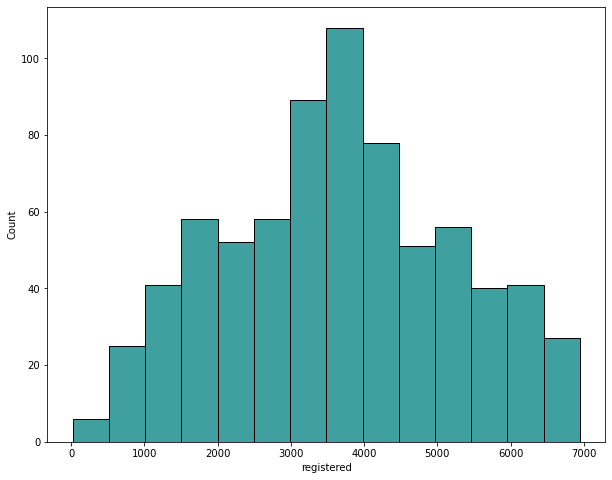

In [117]:
sns.histplot(df['registered'], 
            color = 'teal', 
            kde_kws = {'shade':True, 'linewidth':1});

- Podemos concluir que debido a que tenemos pocos datos recogidos de bicis alquiladas por debajo de los 1500 y por encima de los 5500, nuestro modelo no se puede ajustar a esos datos. Decidimos entonces acotar a ese rango y volver a estudiar el modelo.

In [118]:
df_rango = df[((df['registered'] >= 1500) & (df['registered'] <= 5500))]

In [119]:
df_rango.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
4,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,spring,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
18,spring,0,1,0,3,1,2,11.979134,14.92110,74.1739,13.957239,78,1572,1650
19,spring,0,1,0,4,1,2,10.728347,12.75250,53.8333,13.125568,83,1844,1927
24,spring,0,1,0,2,1,2,9.162598,11.72630,61.6957,8.696332,186,1799,1985


In [120]:
df_rango.shape

(550, 14)

In [121]:
df_rango.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,550.0,0.445455,0.497468,0.000000,0.000000,0.000000,1.000000,1.000000
mnth,550.0,6.623636,3.427918,1.000000,4.000000,6.000000,10.000000,12.000000
holiday,550.0,0.027273,0.163025,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,550.0,2.981818,2.056496,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,550.0,0.660000,0.474140,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,550.0,1.396364,0.535774,1.000000,1.000000,1.000000,2.000000,3.000000
temp,550.0,20.440782,7.153344,4.407500,14.098199,19.867924,26.761028,35.328347
atemp,550.0,23.917114,7.720333,5.966850,17.383900,23.737200,30.287675,42.044800
hum,550.0,62.961875,14.274509,25.416700,51.838325,63.125000,73.437475,97.250000
windspeed,550.0,12.780175,5.105668,1.500244,9.052454,12.313193,15.583714,29.584721


In [122]:
df_rango_boxcox = df_rango.copy()

In [123]:
df_rango_boxcox['registered_boxcox'], lambda_ajustada = stats.boxcox(df_rango['registered']) 

In [172]:
df_rango_num = df_rango.select_dtypes(include=np.number).drop(columns = 'registered', axis=1)

In [173]:
df_rango_num

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,cnt
4,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1600
5,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1606
18,0,1,0,3,1,2,11.979134,14.92110,74.1739,13.957239,78,1650
19,0,1,0,4,1,2,10.728347,12.75250,53.8333,13.125568,83,1927
24,0,1,0,2,1,2,9.162598,11.72630,61.6957,8.696332,186,1985
...,...,...,...,...,...,...,...,...,...,...,...,...
719,1,12,0,5,1,2,13.393347,15.08835,55.6667,25.083661,221,3623
720,1,12,0,6,0,1,10.899153,11.80565,44.1250,27.292182,205,1749
725,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,2114
726,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,3095


In [174]:
min_max = MinMaxScaler()
min_max.fit(df_rango_num)
X_escaladas = min_max.transform(df_rango_num)
X_escaladas

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.92460791e-01, 8.63866548e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.60253099e-01, 1.04259756e-02, 8.96325067e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.43554461e-01, 7.44712541e-03, 7.46937556e-03],
       ...,
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        7.81879151e-01, 5.77896932e-02, 7.67851808e-02],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.17481898e-01, 1.76050045e-01, 2.23334329e-01],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.15990861e-01, 1.14983616e-01, 1.68658500e-01]])

In [175]:
df_rango_boxcox[df_rango_num.columns] = X_escaladas
df_rango_boxcox.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,registered_boxcox
4,spring,0.0,0.0,0.0,0.500000,1.0,0.0,0.158396,0.152355,0.254464,0.392461,0.008639,1518,0.000000,2090.337445
5,spring,0.0,0.0,0.0,0.666667,1.0,0.0,0.128417,0.157814,0.367648,0.160253,0.010426,1518,0.000896,2090.337445


In [176]:
orden_season_rango ={ "spring":3, "winter":2, "summer":1, "autumn":0}

In [177]:
df_rango_boxcox['season'] = df_rango_boxcox['season'].map(orden_season_rango)

In [179]:
x = df_rango_boxcox.drop(columns = ['registered_boxcox']) 
y = df_rango_boxcox[['registered_boxcox']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_test =lr.predict(x_test)
y_pred_train =lr.predict(x_train)

def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

results = metricas(y_test, y_train,y_pred_test, y_pred_train)
results

,MAE,MSE,RMSE,R2,set
0,9.843258,150.549707,12.269870,0.999937,test
1,9.828887,151.163361,12.294851,0.999938,train


In [180]:
inv_boxcox(12.19, lambda_ajustada)

12.169646241251952

- Como podemos comprobar este modelo tiene métricas mucho mejores a las anteriores. El margen de error ha bajado y apenas tienen diferencias entre test y train. Ahora el error sería de 12 bicis.